Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch [1/15], Train Loss: 2.5684, Val Loss: 1.7273, Val Accuracy: 65.29%
Epoch [2/15], Train Loss: 1.1624, Val Loss: 0.8266, Val Accuracy: 87.52%
Epoch [3/15], Train Loss: 0.5676, Val Loss: 0.4795, Val Accuracy: 93.14%
Epoch [4/15], Train Loss: 0.3275, Val Loss: 0.3487, Val Accuracy: 94.28%
Epoch [5/15], Train Loss: 0.2105, Val Loss: 0.2506, Val Accuracy: 96.29%
Epoch [6/15], Train Loss: 0.1403, Val Loss: 0.2003, Val Accuracy: 96.91%
Epoch [7/15], Train Loss: 0.1001, Val Loss: 0.1628, Val Accuracy: 97.37%
Epoch [8/15], Train Loss: 0.0723, Val Loss: 0.1422, Val Accuracy: 97.58%
Epoch [9/15], Train Loss: 0.0534, Val Loss: 0.1206, Val Accuracy: 98.14%
Epoch [10/15], Train Loss: 0.0409, Val Loss: 0.1105, Val Accuracy: 98.09%
Epoch [11/15], Train Loss: 0.0315, Val Loss: 0.1049, Val Accuracy: 98.19%
Epoch [12/15], Train Loss: 0.0247, Val Loss: 0.0946, Val Accuracy:

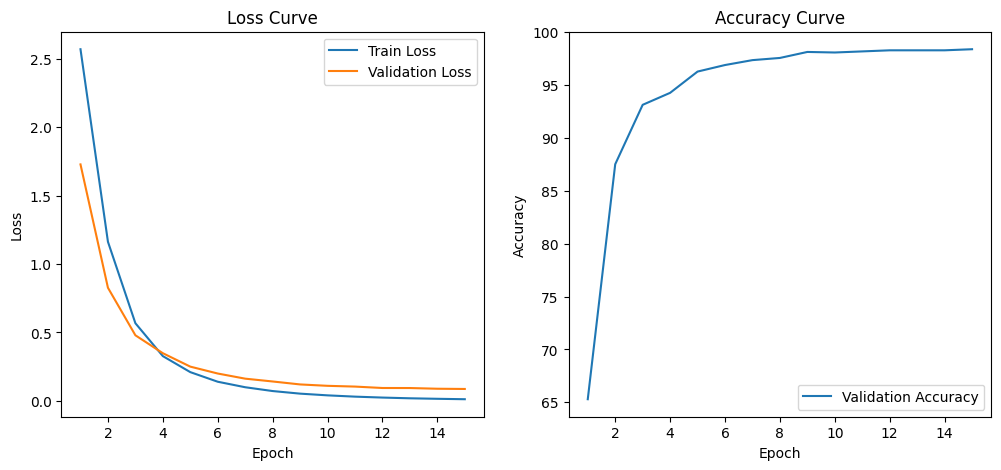

Model loaded from /content/drive/My Drive/modellearnrate1.pth


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),  # If images are RGB, remove this line
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize for grayscale images
])

# Load dataset
dataset_path = '/content/drive/My Drive/character_recognition_dataset/'
dataset = datasets.ImageFolder(dataset_path, transform=transform)

# Calculate dataset sizes for train, validation, and test splits
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 32 * 32, 256)  # Adjusted input size
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, len(dataset.classes))

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize model, criterion, and optimizer
model = SimpleCNN()

# Check for GPU availability and move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5) #changed learning rate to 1e-5

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # Move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move inputs and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Save the trained model
model_save_path = '/content/drive/My Drive/modellearnrate1.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

# Function to display images and predictions
def imshow(img, title):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.show()

# To load the saved model
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.to(device)  # Move the model to GPU if available
    model.eval()
    return model

# Load the saved model (for example, after training is complete)
loaded_model = SimpleCNN()
loaded_model = load_model(loaded_model, model_save_path)
print(f'Model loaded from {model_save_path}')